# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.




## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.


### Inicialización:

In [1]:
# Importamos librerías necesarias :

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [2]:
data_taxi = pd.read_csv('taxi.csv')

In [3]:
display(data_taxi.sample(10))

,datetime,num_orders
5769,2018-04-10 01:30:00,3
4259,2018-03-30 13:50:00,11
23089,2018-08-08 08:10:00,18
25018,2018-08-21 17:40:00,24
8384,2018-04-28 05:20:00,4
4617,2018-04-02 01:30:00,13
8521,2018-04-29 04:10:00,15
8919,2018-05-01 22:30:00,15
24131,2018-08-15 13:50:00,13
17871,2018-07-03 02:30:00,10


In [4]:
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Preparación

In [6]:
data_taxi.columns = data_taxi.columns.str.strip()

In [7]:
data_taxi = data_taxi.rename(columns={'datetime': 'date_time'})

In [8]:
data_taxi['date_time'] = pd.to_datetime(data_taxi['date_time'])
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_time   26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
data_taxi.isna().sum()

date_time     0
num_orders    0
dtype: int64

In [10]:
data_taxi.duplicated().sum()

np.int64(0)

In [11]:
# Establecer la columna de fecha y hora como índice:

data_taxi.set_index('date_time', inplace=True)

In [12]:
# Remuestrear datos por horas sumando los pedidos en intervalos de 1 hora:

data_horario = data_taxi.resample('1H').sum()

C:\Users\Home\AppData\Local\Temp\ipykernel_13228\4216441296.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_horario = data_taxi.resample('1H').sum()


In [13]:
# Mostrar las primeras filas de los datos horarios:

data_horario.head()

,num_orders
date_time,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análisis

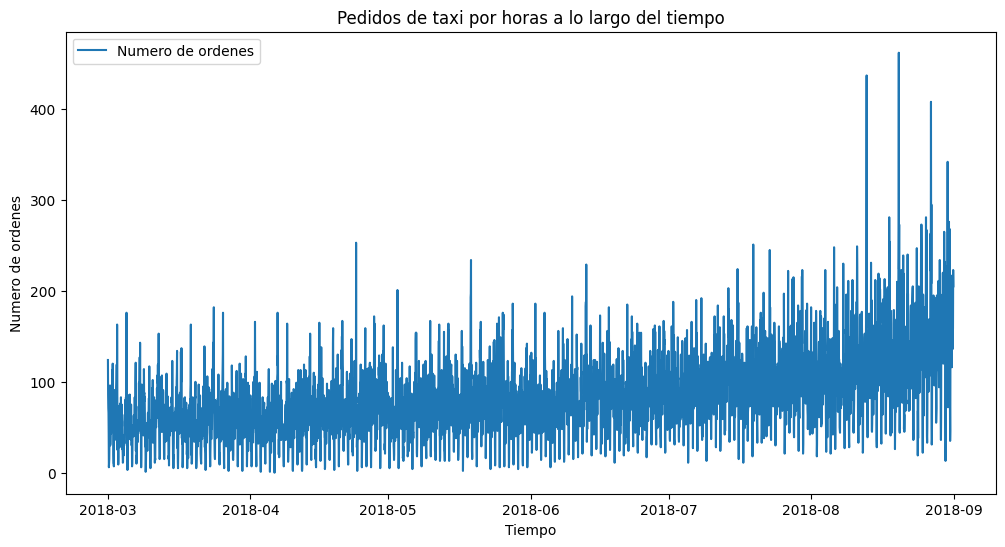

In [14]:

plt.figure(figsize=(12, 6))
plt.plot(data_horario.index, data_horario['num_orders'], label='Numero de ordenes')
plt.title('Pedidos de taxi por horas a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Numero de ordenes')
plt.legend()
plt.show()

El gráfico muestra la evolución de los pedidos por hora, permitiendo identificar posibles patrones de tendencia o estacionalidad.


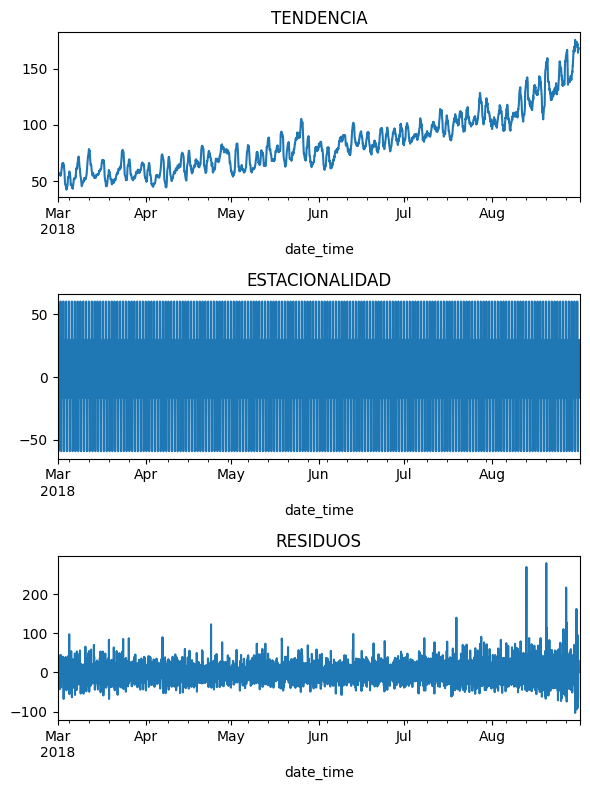

In [15]:
decomposed = seasonal_decompose(data_horario)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('TENDENCIA')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('ESTACIONALIDAD')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('RESIDUOS')
plt.tight_layout()


### Agregar columnas de análisis para identificar tendencias:

In [16]:
# Agregar características de tiempo:

data_horario['hour'] = data_horario.index.hour
data_horario['day_of_week'] = data_horario.index.dayofweek # Día de la semana (0=Lunes, 6=Domingo)
data_horario['day_of_month'] = data_horario.index.day
data_horario['month'] = data_horario.index.month
data_horario['is_weekend'] = data_horario['day_of_week'].isin([5, 6]).astype(int)

#### Análisis promedio por hora del día:

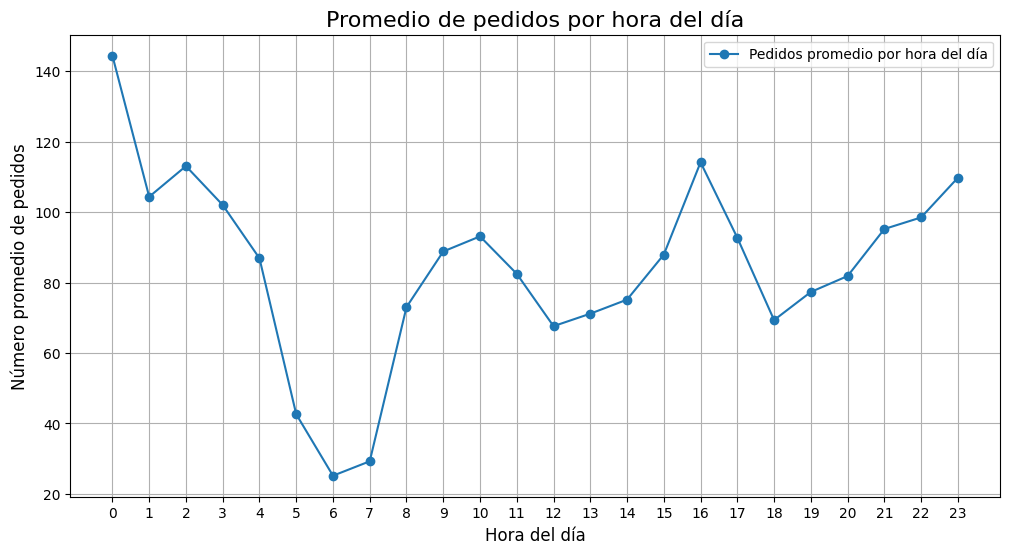

In [17]:
promedio_por_hora = data_horario.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(12, 6))
plt.plot(promedio_por_hora.index, promedio_por_hora.values, marker='o', label='Pedidos promedio por hora del día')
plt.title('Promedio de pedidos por hora del día', fontsize=16)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Número promedio de pedidos', fontsize=12)
plt.grid()
plt.xticks(range(0, 24))
plt.legend()
plt.show()


In [18]:
print(promedio_por_hora.sort_values(ascending=False))

hour
0     144.402174
16    114.146739
2     113.070652
23    109.766304
1     104.364130
3     102.021739
22     98.500000
21     95.211957
10     93.119565
17     92.722826
9      88.831522
15     87.945652
4      86.907609
11     82.489130
20     81.858696
19     77.336957
14     75.163043
8      73.048913
13     71.173913
18     69.358696
12     67.630435
5      42.630435
7      29.271739
6      25.173913
Name: num_orders, dtype: float64


**Análisis por hora del día:**  

Mayor demanda: La hora con más pedidos es a las 0:00 (144.4 pedidos en promedio). 

Menor demanda: Los pedidos disminuyen notablemente entre las 6:00 y las 7:00 (25.2 pedidos en promedio).

#### Análisis promedio por día de la semana:

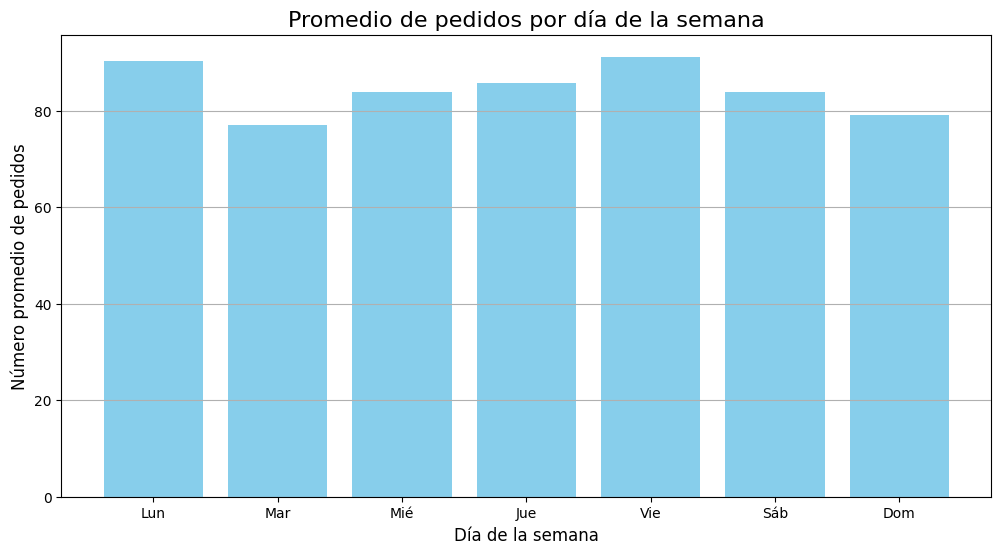

day_of_week
4    91.140432
0    90.246795
3    85.660494
5    83.847756
2    83.754808
6    78.991987
1    77.011218
Name: num_orders, dtype: float64


In [19]:

promedio_por_dia = data_horario.groupby('day_of_week')['num_orders'].mean()

# Visualizar los promedios por día de la semana:

plt.figure(figsize=(12, 6))
plt.bar(promedio_por_dia.index, promedio_por_dia.values, tick_label=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'], color='skyblue')
plt.title('Promedio de pedidos por día de la semana', fontsize=16)
plt.xlabel('Día de la semana', fontsize=12)
plt.ylabel('Número promedio de pedidos', fontsize=12)
plt.grid(axis='y')
plt.show()

print(promedio_por_dia.sort_values(ascending=False))

**Análisis por día de la semana:** 

Mayor demanda: El lunes (90.25 pedidos en promedio) tiene más actividad, posiblemente por el inicio de la semana.  

Menor demanda: El domingo (78.99 pedidos en promedio) muestra una caída, probablemente debido a menor actividad general.

In [20]:
data_horario

,num_orders,hour,day_of_week,day_of_month,month,is_weekend
date_time,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,0
2018-03-01 01:00:00,85,1,3,1,3,0
2018-03-01 02:00:00,71,2,3,1,3,0
2018-03-01 03:00:00,66,3,3,1,3,0
2018-03-01 04:00:00,43,4,3,1,3,0
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,31,8,0
2018-08-31 20:00:00,154,20,4,31,8,0
2018-08-31 21:00:00,159,21,4,31,8,0


## Formación

In [21]:
# Crear características:

"""
    Agrega características de retraso (lags) y promedios móviles a un conjunto de datos.
    """

def add_lag_and_rolling_features (data, max_lag,target_column='num_orders', rolling_windows=[3, 6, 12]):
        
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    #data[f'rolling_mean_{rolling_mean_size}'] = data['num_orders'].rolling(window=rolling_mean_size).mean()#
    
    for window in rolling_windows:
        data[f'rolling_mean_{window}'] = data[target_column].rolling(window=window).mean()
   
    return data.dropna()

# Aplicar la función con max_lag=5 y rolling_mean_size=10

data_horario = add_lag_and_rolling_features(data_horario, target_column='num_orders', max_lag=5, rolling_windows=[3, 6, 12])


In [22]:
data_horario.head()

,num_orders,hour,day_of_week,day_of_month,month,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_3,rolling_mean_6,rolling_mean_12
date_time,,,,,,,,,,,,,,
2018-03-01 11:00:00,96,11,3,1,3,0,64.0,69.0,34.0,15.0,12.0,76.333333,48.333333,57.083333
2018-03-01 12:00:00,30,12,3,1,3,0,96.0,64.0,69.0,34.0,15.0,63.333333,51.333333,49.250000
2018-03-01 13:00:00,32,13,3,1,3,0,30.0,96.0,64.0,69.0,34.0,52.666667,54.166667,44.833333
2018-03-01 14:00:00,48,14,3,1,3,0,32.0,30.0,96.0,64.0,69.0,36.666667,56.500000,42.916667
2018-03-01 15:00:00,66,15,3,1,3,0,48.0,32.0,30.0,96.0,64.0,48.666667,56.000000,42.916667


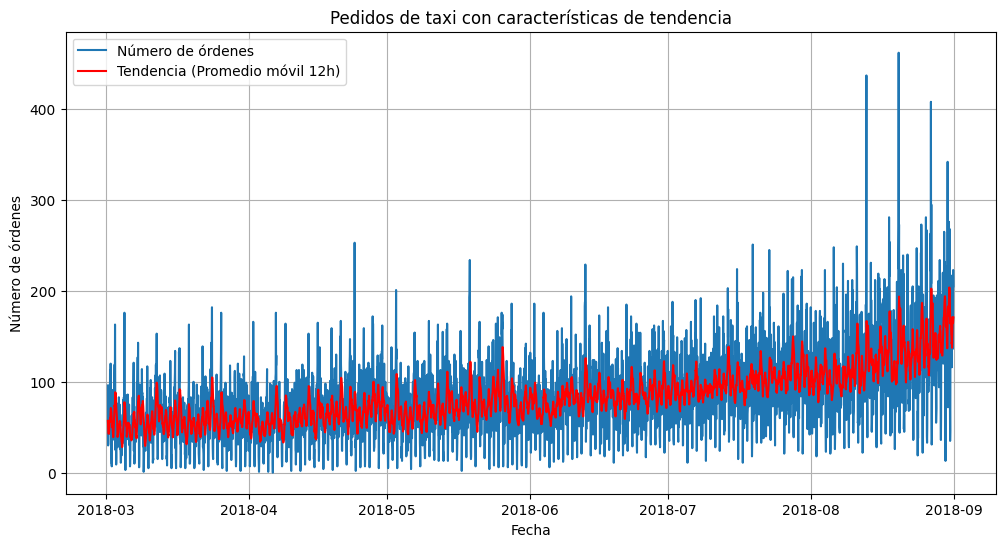

In [23]:
# Visualización de las características agregadas
plt.figure(figsize=(12, 6))
plt.plot(data_horario.index, data_horario['num_orders'], label='Número de órdenes')
plt.plot(data_horario.index, data_horario['rolling_mean_12'], label='Tendencia (Promedio móvil 12h)', color='red')
plt.title('Pedidos de taxi con características de tendencia')
plt.xlabel('Fecha')
plt.ylabel('Número de órdenes')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Dividir en características (X) y objetivo (y):

X = data_horario.drop('num_orders', axis=1)

y = data_horario['num_orders']

In [25]:
# Dividir en conjuntos de prueba (10%) y entrenamiento-validación (90%)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Dividir entrenamiento-validación en entrenamiento (80%) y validación (20%)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=False)

# Mostrar dimensiones de los conjuntos
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

X_train: (3171, 13), X_val: (793, 13), X_test: (441, 13)
y_train: (3171,), y_val: (793,), y_test: (441,)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Prueba

In [27]:

# Modelos básicos:

#model_lr = LinearRegression()
model_dt = DecisionTreeRegressor(random_state=42)
model_rf = RandomForestRegressor(random_state=42, n_estimators=100)
model_lgb = lgb.LGBMRegressor(random_state=42, n_estimators=100)

# Entrenar y evaluar los modelos en validación

models = {
      #'Linear Regression': model_lr,
    'Decision Tree': model_dt,
    'Random Forest': model_rf,
    'LightGBM': model_lgb
}

rmse_scores = {}

for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predicción en validación
    y_pred = model.predict(X_test)
    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[name] = rmse
    print(f"{name}: RMSE en validación = {rmse:.2f}")

# Identificar el mejor modelo
best_model_name = min(rmse_scores, key=rmse_scores.get)

print(f"El mejor modelo es {best_model_name} con RMSE = {rmse_scores[best_model_name]:.2f}")


Decision Tree: RMSE en validación = 51.33
Random Forest: RMSE en validación = 41.85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 3171, number of used features: 13
[LightGBM] [Info] Start training from score 71.333964
LightGBM: RMSE en validación = 42.75
El mejor modelo es Random Forest con RMSE = 41.85


In [28]:
# Probar el modelo optimizado (ejemplo con LightGBM):

y_pred_test = model_lgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"RMSE en el conjunto de prueba: {rmse_test:.2f}")
if rmse_test <= 48:
    print("El modelo cumple con el objetivo de RMSE ≤ 48.")
else:
    print("El modelo NO cumple con el objetivo de RMSE ≤ 48.")

RMSE en el conjunto de prueba: 42.75
El modelo cumple con el objetivo de RMSE ≤ 48.


#  Conclusion

El objetivo del proyecto era predecir la cantidad de pedidos de taxis para la próxima hora utilizando datos históricos de pedidos de la compañía Sweet Lift Taxi. El modelo debía cumplir con la métrica de desempeño definida: una raíz del error cuadrático medio (RMSE) no mayor a 48 en el conjunto de prueba.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48